In [266]:
import torch
print(torch.cuda.is_available())
import torchsort

True


## Loss test: Spearman loss and weighted Spearman loss
Let's do this:

    we have a list of ages 

    we predict a list of health level, 

    we want the health level and the age are positive correlated to each other 
    
details:

age <- 100 random ints

health level <- gaussian noise + age (as ground truth)

pred <- 100 random numbers

set spearman loss and weighted spearman loss to min loss(pred,age)

and evaluate by spearman_corelation_coinficient(pred,health level)

In [26]:
def get_rank(x, indices):
   vals = x[range(len(x)), indices]
   return (x < vals[:, None]).long().sum(1)

In [165]:
def spearman_hard(traget1, pred):
    pred = get_rank(pred, [i for i in range(pred.shape[1])]).float()
    traget1 = get_rank(traget1, [i for i in range(traget1.shape[1])]).float()
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    traget1 = traget1 - traget1.mean()
    traget1 = traget1 / traget1.norm()
    return (pred * traget1).sum()

def weighted_spearmanr(pred, target, target_sort, **kw):
    pred_rank = torchsort.soft_rank(pred, **kw)
    target_rank = torchsort.soft_rank(target, **kw)
    
    target_sort = target_sort.flatten()
    w = torch.sqrt( (target_sort[pred_rank.flatten().long()-1] - target_sort[target_rank.flatten().long()-1]) ** 2 ).requires_grad_(False)
    # w = torch.tensor([0,0,0,0,19])
    pred_rank = pred_rank - pred_rank.mean()
    pred_rank = pred_rank / pred_rank.norm()
    target_rank = target_rank - target_rank.mean()
    target_rank = target_rank / target_rank.norm()
    
    k = 2
    w = 1/(1 + torch.exp(-k*(w-5)))

    return (pred_rank * target_rank * w).sum(), w

def spearmanr(pred, target, **kw):
    pred = torchsort.soft_rank(pred, **kw)
    target = torchsort.soft_rank(target, **kw)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    return (pred * target).sum()

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt

noise_level = 15
loop_max = 100
data_width = 100
data_spearman_vs_test = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_test = np.zeros((noise_level,loop_max))
data_spearman_vs_input = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_input = np.zeros((noise_level,loop_max))
sigma = 5
alpha1 = 5
alpha2 = 15
for sigma in range(0, noise_level):
    for loop_i in range(loop_max):
        # target is 100 random integers between 55 and 95
        target = torch.randint(55, 95, (1,data_width)).float()
        # target = torch.tensor([[55., 55., 56., 64., 75., 55., 55., 56., 64., 75.]])
        pred = torch.randint(0, 10, (1,data_width)) + 0.5 * torch.rand((1,data_width))
        ages_rank = torchsort.soft_rank(target, regularization_strength=0.1)
        pred.requires_grad = True
        target_sort = torch.sort(target, dim=1, descending=False)[0]

        target_gt = target + torch.randn(target.shape) * sigma
        # print("target_gt: ", target_gt)
        # print("pred: ", pred)
        # # get_rank(target_gt, [i for i in range(target_gt.shape[1])])
        # # target_gt = get_rank(target_gt, [i for i in range(target_gt.shape[1])])

        # print("pred rank: ", get_rank(pred, [i for i in range(pred.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # # spearman_hard(target_gt, pred)

        pred.requires_grad = True
        pred_loop_spearman = pred.clone()
        pred_loop_weighted_spearman = pred.clone()
        for i in range(500):
            spearman = spearmanr(pred_loop_spearman, target)
            grad = torch.autograd.grad(spearman, pred_loop_spearman)
            pred_loop_spearman +=  alpha1 * grad[0] ######################### ?????????????????????????????????? why + not -?
            # print("pred_loop_spearman: ", pred_loop_spearman)

            weighted_spearman, w = weighted_spearmanr(pred_loop_weighted_spearman, target, target_sort)
            grad = torch.autograd.grad(weighted_spearman, pred_loop_weighted_spearman)
            pred_loop_weighted_spearman += alpha2 * grad[0] 
            # print("pred_loop_weighted_spearman: ", pred_loop_weighted_spearman)
            
        # print("pred spearman rank: ", get_rank(pred_loop_spearman, [i for i in range(pred_loop_spearman.shape[1])]))
        # print("pred weighted_spearman rank: ", get_rank(pred_loop_weighted_spearman, [i for i in range(pred_loop_weighted_spearman.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # print("target rank: ", get_rank(target, [i for i in range(target.shape[1])]))
        loss_spearman = spearman_hard(target_gt, pred_loop_spearman)
        loss_weight_spearman = spearman_hard(target_gt, pred_loop_weighted_spearman)
        print("loss_spearman: ", loss_spearman)
        print("loss_weight_spearman: ", loss_weight_spearman)

        loss_spearman_origin = spearman_hard(target, pred_loop_spearman)
        loss_weight_spearman_origin = spearman_hard(target, pred_loop_weighted_spearman)

        data_spearman_vs_test[sigma,loop_i] = loss_spearman
        data_weighted_spearman_vs_test[sigma,loop_i] = loss_weight_spearman

        data_spearman_vs_input[sigma,loop_i] = loss_spearman_origin
        data_weighted_spearman_vs_input[sigma,loop_i] = loss_weight_spearman_origin
        # print("loss_spearman_origin: ", loss_spearman_origin)
        # print("loss_weight_spearman_origin: ", loss_weight_spearman_origin)

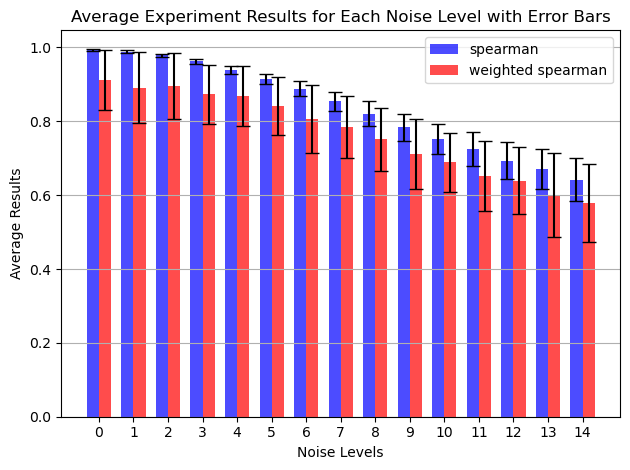

In [251]:

std_values_spearman_vs_test = np.std(data_spearman_vs_test, axis=1)
mean_values_spearman_vs_test = np.mean(data_spearman_vs_test, axis=1)
std_values_spearman_vs_input = np.std(data_spearman_vs_input, axis=1)
mean_values_spearman_vs_input = np.mean(data_spearman_vs_input, axis=1)
std_values_weighted_spearman_vs_test = np.std(data_weighted_spearman_vs_test, axis=1)
mean_values_weighted_spearman_vs_test = np.mean(data_weighted_spearman_vs_test, axis=1)
std_values_weighted_spearman_vs_input = np.std(data_weighted_spearman_vs_input, axis=1)
mean_values_weighted_spearman_vs_input = np.mean(data_weighted_spearman_vs_input, axis=1)

import matplotlib.pyplot as plt

# Noise levels (could be actual noise values if available)
noise_levels = np.arange(noise_level)

# Bar width and shifted positions
bar_width = 0.35
positions1 = noise_levels - bar_width/2
positions2 = noise_levels + bar_width/2

# Plot for matrix1
plt.bar(positions1, mean_values_spearman_vs_test, bar_width, yerr=std_values_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='blue', label='spearman')

# Plot for matrix2
plt.bar(positions2, mean_values_weighted_spearman_vs_test, bar_width, yerr=std_values_weighted_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='red', label='weighted spearman')

plt.xlabel('Noise Levels')
plt.ylabel('Average Results')
plt.title('Average Experiment Results for Each Noise Level with Error Bars')
plt.xticks(noise_levels)  # Set the tick labels as the noise levels
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()






## Another test
Details:

health_level <- 100 integers between 0-9

age = health_level * 4 + 55 + randint(-5,5)

pred <- random number

min loss(pred,age) (loss is spearman loss and weighted spearman )

evaluate by spearman_corelation_coinficient(pred,health_level)


In [252]:
def spearman_hard(traget1, pred):
    pred = get_rank(pred, [i for i in range(pred.shape[1])]).float()
    traget1 = get_rank(traget1, [i for i in range(traget1.shape[1])]).float()
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    traget1 = traget1 - traget1.mean()
    traget1 = traget1 / traget1.norm()
    return (pred * traget1).sum()

def weighted_spearmanr(pred, target, target_sort, k=2, s=5, **kw):
    pred_rank = torchsort.soft_rank(pred, **kw)
    target_rank = torchsort.soft_rank(target, **kw)
    
    target_sort = target_sort.flatten()
    W = torch.sqrt( (target_sort[pred_rank.flatten().long()-1] - target_sort[target_rank.flatten().long()-1]) ** 2 ).requires_grad_(False)
    # w = torch.tensor([0,0,0,0,19])
    pred_rank = pred_rank - pred_rank.mean()
    pred_rank = pred_rank / pred_rank.norm()
    target_rank = target_rank - target_rank.mean()
    target_rank = target_rank / target_rank.norm()
    
    W = 1/(1 + torch.exp(-k*(W-s)))

    return (pred_rank * target_rank * W).sum(), W

def spearmanr(pred, target, **kw):
    pred = torchsort.soft_rank(pred, **kw)
    target = torchsort.soft_rank(target, **kw)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    return (pred * target).sum()

In [ ]:
noise_level = 15
loop_max = 100
data_width = 100
data_spearman_vs_test = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_test = np.zeros((noise_level,loop_max))
data_spearman_vs_input = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_input = np.zeros((noise_level,loop_max))
sigma = 5
alpha1 = 25
alpha2 = 250
for sigma in range(0, noise_level):
    for loop_i in range(loop_max):
        # health_level is random integers between 0-9, total data_width
        health_level = torch.randint(0, 10, (1,data_width)).float()

        # age is health_level * 4 + 55 + rand ints between -sigma to sigma
        if sigma != 0:
            age = health_level * 4 + 55 + torch.randint(-sigma, sigma, (1,data_width)).float()
        else:
            age = health_level * 4 + 55
        # pred is random numbers with normal distribution, total data_width
        pred = torch.randn(1,data_width)

        pred = torch.randint(0, 10, (1,data_width)) + 0.5 * torch.rand((1,data_width))

        pred.requires_grad = True
        age_sort = torch.sort(age, dim=1, descending=False)[0]

        # print("target_gt: ", target_gt)
        # print("pred: ", pred)
        # # get_rank(target_gt, [i for i in range(target_gt.shape[1])])
        # # target_gt = get_rank(target_gt, [i for i in range(target_gt.shape[1])])

        # print("pred rank: ", get_rank(pred, [i for i in range(pred.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # # spearman_hard(target_gt, pred)

        pred_loop_spearman = pred.clone()
        pred_loop_weighted_spearman = pred.clone()
        for i in range(100):
            spearman = spearmanr(pred_loop_spearman, age)
            grad = torch.autograd.grad(spearman, pred_loop_spearman)
            pred_loop_spearman +=  alpha1 * grad[0] ######################### ?????????????????????????????????? why + not -?
            # print("pred_loop_spearman: ", pred_loop_spearman)

            weighted_spearman, w = weighted_spearmanr(pred_loop_weighted_spearman, age, age_sort)
            grad = torch.autograd.grad(weighted_spearman, pred_loop_weighted_spearman)
            pred_loop_weighted_spearman += alpha2 * grad[0] 
            # print("pred_loop_weighted_spearman: ", pred_loop_weighted_spearman)
            
        # print("pred spearman rank: ", get_rank(pred_loop_spearman, [i for i in range(pred_loop_spearman.shape[1])]))
        # print("pred weighted_spearman rank: ", get_rank(pred_loop_weighted_spearman, [i for i in range(pred_loop_weighted_spearman.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # print("target rank: ", get_rank(target, [i for i in range(target.shape[1])]))
        loss_spearman = spearman_hard(health_level, pred_loop_spearman)
        loss_weight_spearman = spearman_hard(health_level, pred_loop_weighted_spearman)
        print("loss_spearman: ", loss_spearman)
        print("loss_weight_spearman: ", loss_weight_spearman)

        loss_spearman_origin = spearman_hard(age, pred_loop_spearman)
        loss_weight_spearman_origin = spearman_hard(age, pred_loop_weighted_spearman)

        data_spearman_vs_test[sigma,loop_i] = loss_spearman
        data_weighted_spearman_vs_test[sigma,loop_i] = loss_weight_spearman

        data_spearman_vs_input[sigma,loop_i] = loss_spearman_origin
        data_weighted_spearman_vs_input[sigma,loop_i] = loss_weight_spearman_origin
        # print("loss_spearman_origin: ", loss_spearman_origin)
        # print("loss_weight_spearman_origin: ", loss_weight_spearman_origin)

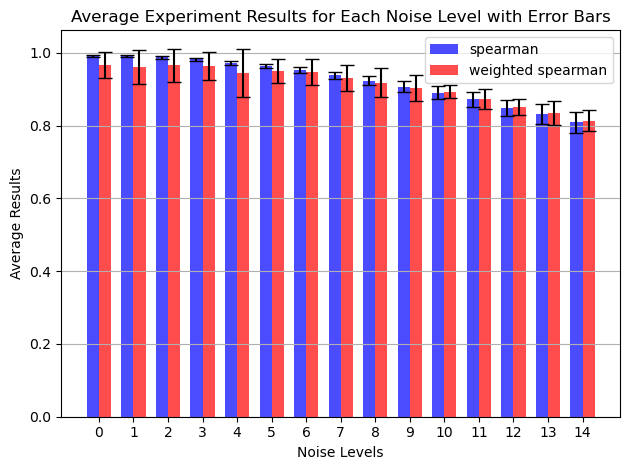

In [264]:
std_values_spearman_vs_test = np.std(data_spearman_vs_test, axis=1)
mean_values_spearman_vs_test = np.mean(data_spearman_vs_test, axis=1)
# std_values_spearman_vs_input = np.std(data_spearman_vs_input, axis=1)
# mean_values_spearman_vs_input = np.mean(data_spearman_vs_input, axis=1)
std_values_weighted_spearman_vs_test = np.std(data_weighted_spearman_vs_test, axis=1)
mean_values_weighted_spearman_vs_test = np.mean(data_weighted_spearman_vs_test, axis=1)
# std_values_weighted_spearman_vs_input = np.std(data_weighted_spearman_vs_input, axis=1)
# mean_values_weighted_spearman_vs_input = np.mean(data_weighted_spearman_vs_input, axis=1)

import matplotlib.pyplot as plt

# Noise levels (could be actual noise values if available)
noise_levels = np.arange(noise_level)

# Bar width and shifted positions
bar_width = 0.35
positions1 = noise_levels - bar_width/2
positions2 = noise_levels + bar_width/2

# Plot for matrix1
plt.bar(positions1, mean_values_spearman_vs_test, bar_width, yerr=std_values_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='blue', label='spearman')

# Plot for matrix2
plt.bar(positions2, mean_values_weighted_spearman_vs_test, bar_width, yerr=std_values_weighted_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='red', label='weighted spearman')

plt.xlabel('Noise Levels')
plt.ylabel('Average Results')
plt.title('Average Experiment Results for Each Noise Level with Error Bars')
plt.xticks(noise_levels)  # Set the tick labels as the noise levels
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
noise_level = 20
min_noise = 15
loop_max = 200
data_width = 100
data_spearman_vs_test = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_test = np.zeros((noise_level,loop_max))
data_spearman_vs_input = np.zeros((noise_level,loop_max))
data_weighted_spearman_vs_input = np.zeros((noise_level,loop_max))

alpha1 = 20
alpha2 = 200
for sigma in range(min_noise, min_noise + noise_level):
    for loop_i in range(loop_max):
        # health_level is random integers between 0-9, total data_width
        health_level = torch.randint(0, 10, (1,data_width)).float()

        # age is health_level * 4 + 55 + rand ints between -sigma to sigma
        if sigma != 0:
            age = health_level * 4 + 55 + torch.randint(-sigma, sigma, (1,data_width)).float()
        else:
            age = health_level * 4 + 55
        # pred is random numbers with normal distribution, total data_width
        pred = torch.randn(1,data_width)

        pred = torch.randint(0, 10, (1,data_width)) + 0.5 * torch.rand((1,data_width))

        pred.requires_grad = True
        age_sort = torch.sort(age, dim=1, descending=False)[0]

        # print("target_gt: ", target_gt)
        # print("pred: ", pred)
        # # get_rank(target_gt, [i for i in range(target_gt.shape[1])])
        # # target_gt = get_rank(target_gt, [i for i in range(target_gt.shape[1])])

        # print("pred rank: ", get_rank(pred, [i for i in range(pred.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # # spearman_hard(target_gt, pred)

        pred_loop_spearman = pred.clone()
        pred_loop_weighted_spearman = pred.clone()
        for i in range(100):
            spearman = spearmanr(pred_loop_spearman, age)
            grad = torch.autograd.grad(spearman, pred_loop_spearman)
            pred_loop_spearman +=  alpha1 * grad[0] ######################### ?????????????????????????????????? why + not -?
            # print("pred_loop_spearman: ", pred_loop_spearman)

            weighted_spearman, w = weighted_spearmanr(pred_loop_weighted_spearman, age, age_sort)
            grad = torch.autograd.grad(weighted_spearman, pred_loop_weighted_spearman)
            pred_loop_weighted_spearman += alpha2 * grad[0] 
            # print("pred_loop_weighted_spearman: ", pred_loop_weighted_spearman)
            
        # print("pred spearman rank: ", get_rank(pred_loop_spearman, [i for i in range(pred_loop_spearman.shape[1])]))
        # print("pred weighted_spearman rank: ", get_rank(pred_loop_weighted_spearman, [i for i in range(pred_loop_weighted_spearman.shape[1])]))
        # print("target_gt rank: ", get_rank(target_gt, [i for i in range(target_gt.shape[1])]))
        # print("target rank: ", get_rank(target, [i for i in range(target.shape[1])]))
        loss_spearman = spearman_hard(health_level, pred_loop_spearman)
        loss_weight_spearman = spearman_hard(health_level, pred_loop_weighted_spearman)
        print("loss_spearman: ", loss_spearman)
        print("loss_weight_spearman: ", loss_weight_spearman)

        loss_spearman_origin = spearman_hard(age, pred_loop_spearman)
        loss_weight_spearman_origin = spearman_hard(age, pred_loop_weighted_spearman)

        data_spearman_vs_test[sigma-min_noise,loop_i] = loss_spearman
        data_weighted_spearman_vs_test[sigma-min_noise,loop_i] = loss_weight_spearman

        data_spearman_vs_input[sigma-min_noise,loop_i] = loss_spearman_origin
        data_weighted_spearman_vs_input[sigma-min_noise,loop_i] = loss_weight_spearman_origin
        # print("loss_spearman_origin: ", loss_spearman_origin)
        # print("loss_weight_spearman_origin: ", loss_weight_spearman_origin)

std_values_spearman_vs_test = np.std(data_spearman_vs_test, axis=1)
mean_values_spearman_vs_test = np.mean(data_spearman_vs_test, axis=1)
# std_values_spearman_vs_input = np.std(data_spearman_vs_input, axis=1)
# mean_values_spearman_vs_input = np.mean(data_spearman_vs_input, axis=1)
std_values_weighted_spearman_vs_test = np.std(data_weighted_spearman_vs_test, axis=1)
mean_values_weighted_spearman_vs_test = np.mean(data_weighted_spearman_vs_test, axis=1)
# std_values_weighted_spearman_vs_input = np.std(data_weighted_spearman_vs_input, axis=1)
# mean_values_weighted_spearman_vs_input = np.mean(data_weighted_spearman_vs_input, axis=1)

import matplotlib.pyplot as plt

# Noise levels (could be actual noise values if available)
noise_levels = np.arange(noise_level) + min_noise

# Bar width and shifted positions
bar_width = 0.35
positions1 = noise_levels - min_noise - bar_width/2
positions2 = noise_levels - min_noise + bar_width/2

# Plot for matrix1
plt.bar(positions1, mean_values_spearman_vs_test, bar_width, yerr=std_values_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='blue', label='spearman')

# Plot for matrix2
plt.bar(positions2, mean_values_weighted_spearman_vs_test, bar_width, yerr=std_values_weighted_spearman_vs_test, align='center', 
        alpha=0.7, capsize=5, color='red', label='weighted spearman')

plt.xlabel('Noise Levels')
plt.ylabel('Average Results')
plt.title('Average Experiment Results for Each Noise Level with Error Bars')
plt.xticks(noise_levels)  # Set the tick labels as the noise levels
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()
